In [1]:

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import cv2 as cv

import argparse
import pickle
import math
import numpy as np
import random
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import pandas as pd

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 23 10:21:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def tamga_28():
    
    # Downloaded from http://deeplearning.net/data/mnist/mnist.pkl.gz
    
    return np.load('/content/drive/MyDrive/Thesis /experiments/poky_28.npy')

"""
Give the training images from the cropped LFW dataset
"""
def loadLFW():
    # 32x32 version of grayscale cropped LFW
    # Original dataset here: http://conradsanderson.id.au/lfwcrop/
    return np.load('/content/drive/MyDrive/Thesis /experiments/tamga_64_hind2.npy',allow_pickle=True)

"""
Return a TF variable with zeros of provided shape
"""
def zeros(shape):

    return tf.Variable(tf.zeros(shape))

"""
Return a TF variable with numbers drawn from a normal distribution of zero mean
and given standard deviation
"""
def normal(shape, std_dev):

    return tf.Variable(tf.random.normal(shape, stddev = std_dev))

In [ ]:
tt=loadLFW()
tt.shape

(2860, 4096)

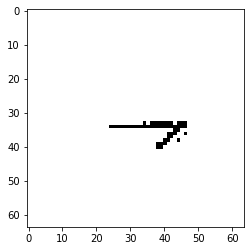

In [ ]:
#%matplotlib.inline
plt.imshow(tt[543].reshape(64,64),'gray')

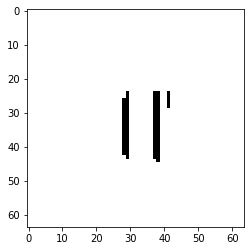

In [ ]:
plt.imshow(tt[110].reshape(64,64),'gray')

In [ ]:
%%time
ss=loadLFW()


CPU times: user 1.1 ms, sys: 9.63 ms, total: 10.7 ms
Wall time: 20.5 ms


In [ ]:
ss.shape

(14305, 4096)

In [ ]:
len(ss)

14305

In [4]:
class ReLULayer():

    """
    Initialize layer object with the given input and output dimensions

    input_dim:  Dimension of inputs to the layer
    output_dim: Dimension of outputs of the layer
    """
    def __init__(self, input_dim, output_dim):

        # initialize weights and biases for the layer
        self.W = normal([input_dim, output_dim], 1.0 / math.sqrt(input_dim))
        self.b = zeros([output_dim])

    """
    Forward propagation in the layer

    x: Input to the layer
    """
    def forward(self, x):

        return tf.nn.relu(tf.matmul(x, self.W) + self.b)



class SigmoidLayer():

    """
    Initialize layer object with the given input, output dimensions and dropout
    retention probabilities

    input_dim:    Dimension of inputs to the layer
    output_dim:   Dimension of outputs of the layer
    dropout_prob: Fraction of dropout retention in the layer
    """
    def __init__(self, input_dim, output_dim, dropout_prob = 1.0):

        # initialize weights and biases for the layer
        self.W = normal([input_dim, output_dim], 1.0 / math.sqrt(input_dim))
        self.b = zeros([output_dim])

        # store the dropout retention probability for later use
        self.dropout_prob = dropout_prob

    """
    Forward propagation in the layer

    x: Input to the layer
    """
    def forward(self, x):

        return tf.sigmoid(tf.matmul(tf.nn.dropout(x, self.dropout_prob),
                          self.W) + self.b)

In [5]:
class DataSpaceNetwork():

    """
    Initialize network object with the given dimensions and batch size

    dimensions: Dimensions of the all the layers of the network, including
                input and output
    batch_size: Number of training examples taken in the batch
    """
    def __init__(self, dimensions, batch_size):

        # store 'dimensions' and 'batch_size' for later use
        self.dimensions = dimensions
        self.batch_size = batch_size

        # store the layers as a list
        self.layers = []

        # all the layers except the last one is 'ReLU'
        for dim_index in range(len(dimensions)-2):
            self.layers.append(ReLULayer(dimensions[dim_index],
                                         dimensions[dim_index+1]))

        # last layer is 'Sigmoid' as we need the outputs to be in [0, 1]
        self.layers.append(SigmoidLayer(dimensions[dim_index+1],
                                        dimensions[dim_index+2]))

    """
    Forward propagation of the network

    x: Input batch of samples from the uniform
    """
    def forward(self, x):

        # initialize the first 'hidden' layer to the input
        h = x

        # for all the layers propagate the activation forward
        # all layers have the 'forward()' method
        for dim_index in range(len(self.dimensions)-1):
            h = self.layers[dim_index].forward(h)

        return h

    """
    Scale column for the MMD measure

    num_gen:  Number of samples to be generated in one pass, 'N' in the paper
    num_orig: Number of samples taken from dataset in one pass, 'M' in the paper
    """
    def makeScaleMatrix(self, num_gen, num_orig):

        # first 'N' entries have '1/N', next 'M' entries have '-1/M'
        s1 =  tf.constant(1.0 / num_gen, shape = [num_gen, 1])
        s2 = -tf.constant(1.0 / num_orig, shape = [num_orig, 1])

        return tf.concat( [s1, s2],0)

    """
    Calculates cost of the network, which is square root of the mixture of 'K'
    RBF kernels

    x:       Batch from the dataset
    samples: Samples from the uniform distribution
    sigma:   Bandwidth parameters for the 'K' kernels
    """
    def computeLoss(self, x, samples, sigma = [2, 5, 10, 20, 40, 80]):

        # generate images from the provided uniform samples
        gen_x = self.forward(samples)

        # concatenation of the generated images and images from the dataset
        # first 'N' rows are the generated ones, next 'M' are from the data
        X = tf.concat( [gen_x, x],0)

        # dot product between all combinations of rows in 'X'
        XX = tf.matmul(X, tf.transpose(X))

        # dot product of rows with themselves
        X2 = tf.reduce_sum(X * X, 1, keep_dims = True)

        # exponent entries of the RBF kernel (without the sigma) for each
        # combination of the rows in 'X'
        # -0.5 * (x^Tx - 2*x^Ty + y^Ty)
        exponent = XX - 0.5 * X2 - 0.5 * tf.transpose(X2)

        # scaling constants for each of the rows in 'X'
        s = self.makeScaleMatrix(self.batch_size, self.batch_size)

        # scaling factors of each of the kernel values, corresponding to the
        # exponent values
        S = tf.matmul(s, tf.transpose(s))

        loss = 0

        # for each bandwidth parameter, compute the MMD value and add them all
        for i in range(len(sigma)):

            # kernel values for each combination of the rows in 'X' 
            kernel_val = tf.exp(1.0 / sigma[i] * exponent)
            loss += tf.reduce_sum(S * kernel_val)

        return tf.sqrt(loss)

In [6]:
def generateFigure(samples, num_rows, num_cols, image_side, file_name):

    # initialize the figure object
    figure, axes = plt.subplots(nrows = num_rows, ncols = num_cols)
     
    index = 0
    # take the first 'num_rows * num_cols' samples from the provided batch
    for axis in axes.flat:
        image = axis.imshow(samples[index, :].reshape(image_side, image_side),
                            cmap = plt.cm.gray, interpolation = 'nearest')
        axis.set_frame_on(False)
        axis.set_axis_off()
        index += 1 

    # save the figure
    figure.savefig(file_name)



In [ ]:
ss=loadLFW()
len(ss)

11440

In [16]:
from tqdm.notebook import tqdm

def trainDataSpaceNetwork(dataset):

    # batch size for the training
    batch_size = 1000

    # parameters and training set for MNIST
    if dataset == 'tamga_28':
        input_dim    = 784
        image_side   = 28
        num_examples = 819
        train_x      = tamga_28()

    # parameters and training set for LFW
    elif dataset == 'lfw':
        input_dim    = 64*64
        image_side   = 64
        num_examples = 2860
        train_x      = loadLFW()

    # dimensions of the moment matching network
    data_space_dims =  [10, 64, 256, 256, input_dim]
                      
                      
                      #1  [10, 32, 64,128,256, 512, input_dim]
                      # 2 [ 32, 64,128,256, 512, input_dim]
                      # 3 [16, 32,64, 128, 256, 512,1024, input_dim]

    # get a DataSpaceNetwork object
    data_space_network = DataSpaceNetwork(data_space_dims, batch_size)

    # placeholders for the data batch and the uniform samples respectively
    x       = tf.placeholder("float", [batch_size, input_dim])
    samples = tf.placeholder("float", [batch_size, data_space_dims[0]])
    
    # cost of the network, and optimizer for the cost
    cost      = data_space_network.computeLoss(x, samples)
    optimizer = tf.train.AdamOptimizer(0.0005).minimize(cost)

    # generator for the network
    generate = data_space_network.forward(samples)

    # initalize all the variables in the model
    init = tf.initialize_all_variables()
    sess = tf.Session()
    sess.run(init)

    # number of batches to train the model on, and frequency of printing out the
    # cost
    num_iterations  = 40001
    iteration_break = 1000

    for i in tqdm(range(num_iterations)):

        # sample a random batch from the training set
        batch_indices = np.random.randint(num_examples, size = batch_size)
        batch_x       = train_x[batch_indices]
        batch_uniform = np.random.uniform(low = -1.0, high = 1.0,
            size = (batch_size, data_space_dims[0]))

        # print out the cost after every 'iteration_break' iterations
        if i % iteration_break == 0:
            curr_cost = sess.run(cost, feed_dict = {samples: batch_uniform,
                                                    x: batch_x})
            print( 'Cost at iteration ' + str(i+1) + ': ' + str(curr_cost))

        # optimize the network
        sess.run(optimizer, feed_dict = {samples: batch_uniform, x: batch_x})

    # parameters for figure generation
    num_rows = 8; num_cols = 8

    # generate samples from the trained network
    batch_uniform = np.random.uniform(low = -1.0, high = 1.0,
        size = (batch_size, data_space_dims[0]))
    gen_samples   = sess.run(generate, feed_dict = {samples: batch_uniform})

    # generate figure of generated samples
    file_name = dataset + '_data_space.png'
    generateFigure(gen_samples, num_rows, num_cols, image_side, file_name)

Cost at iteration 1: 2.349861
Cost at iteration 1001: 0.21883886
Cost at iteration 2001: 0.16413757
Cost at iteration 3001: 0.14934388
Cost at iteration 4001: 0.14509773
Cost at iteration 5001: 0.14289433
Cost at iteration 6001: 0.13103734
Cost at iteration 7001: 0.13598362
Cost at iteration 8001: 0.13290082
Cost at iteration 9001: 0.12553845
Cost at iteration 10001: 0.12507321
Cost at iteration 11001: 0.12661578
Cost at iteration 12001: 0.12611414
Cost at iteration 13001: 0.12685868
Cost at iteration 14001: 0.12483647
Cost at iteration 15001: 0.13859598
Cost at iteration 16001: 0.11851703
Cost at iteration 17001: 0.11514326
Cost at iteration 18001: 0.11688559
Cost at iteration 19001: 0.11559621
Cost at iteration 20001: 0.12575951
Cost at iteration 21001: 0.11826521
Cost at iteration 22001: 0.11628322
Cost at iteration 23001: 0.12589312
Cost at iteration 24001: 0.11561133
Cost at iteration 25001: 0.11431573
Cost at iteration 26001: 0.112846754
Cost at iteration 27001: 0.12166577
Cost a

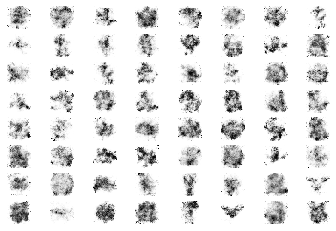

In [17]:
%%time
trainDataSpaceNetwork(dataset='tamga_28')